## MLNS PROJECT : Overlapping Community Detection in graphs: hands on overlapping communities

#### Authors : Adrien FU, Joshua NOULLIER-JACQUES

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from cdlib import evaluation, NodeClustering
from scipy.optimize import linear_sum_assignment
from collections import defaultdict

import community.community_louvain as community_louvain
import leidenalg as la
import igraph as ig

from tqdm import tqdm
import time

# Facebook Graph

We use the Facebook Social Circles Dataset. These are 10 ego-networks with social circles used as groundtruth for community.
(https://snap.stanford.edu/data/ego-Facebook.html)

An ego-network contains all the friends of an individual. The edges in this network indocates that two users (friends with the original user) are friends too.
Additionnaly, Facebook (as some other social networks) provides the possibility for user to manually create their different social circles. This data can be used as a groundtruth for community.

In [2]:
#We first look at the different datasets available

#Possible dataset
ids = [0, 107, 348, 414, 686, 698, 1684, 1912, 3437, 3980]

for id in ids:
    print("==================",id,"==================")
    G = nx.read_edgelist(f"facebook/{id}.edges") 

    mapping = {str_node: int(str_node) for str_node in G.nodes}
    G = nx.relabel_nodes(G, mapping)
    
    print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    
    true_labels = defaultdict(list)
    # Read the .txt file
    with open(f"facebook/{id}.circles", 'r') as file:
        for i, line in enumerate(file):
            parts = line.strip().split()
            for node in parts[1:]:
                true_labels[int(node)].append(i)

    print(f"Number of communities {i+1}")

================== 0 ==================
Graph has 333 nodes and 2519 edges
Number of communities 24
================== 107 ==================
Graph has 1034 nodes and 26749 edges
Number of communities 9
================== 348 ==================
Graph has 224 nodes and 3192 edges
Number of communities 14
================== 414 ==================
Graph has 150 nodes and 1693 edges
Number of communities 7
================== 686 ==================
Graph has 168 nodes and 1656 edges
Number of communities 14
================== 698 ==================
Graph has 61 nodes and 270 edges
Number of communities 13
================== 1684 ==================
Graph has 786 nodes and 14024 edges
Number of communities 17
================== 1912 ==================
Graph has 747 nodes and 30025 edges
Number of communities 46
================== 3437 ==================
Graph has 534 nodes and 4813 edges
Number of communities 32
================== 3980 ==================
Graph has 52 nodes and 146 edges
Numbe

In [3]:
# Choice of the dataset

dataset_id = 348

In [4]:
# Load the edge list
G = nx.read_edgelist(f"facebook/{dataset_id}.edges") 

mapping = {str_node: int(str_node) for str_node in G.nodes}
G = nx.relabel_nodes(G, mapping)

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
print("Graph is connected: ", nx.is_connected(G), "\n")

Graph has 224 nodes and 3192 edges
Graph is connected:  True 



In [5]:
#Get the social circles and store them in true_labels as a groundtruth

true_labels = defaultdict(list)
# Read the .txt file
with open(f"facebook/{dataset_id}.circles", 'r') as file:
    for i, line in enumerate(file):
        parts = line.strip().split()
        for node in parts[1:]:
            true_labels[int(node)].append(i)

print(f"Number of communities {i+1}")

Number of communities 14


### Data Processing

The data need some preprocessing : 
- some nodes are in the graph G but don't belong to any community. We choose to create new communities, where each one of them contains only one node that doesn't belong to any circle.
- some nodes appear in the circles but aren't part of the graph G. That means that they're part of a circle of one of the friends of the original user but aren't friends with this original user.

In [6]:
L = []
for node in G.nodes():
    if node not in true_labels.keys():
        L.append(node)
print(f'Nodes that are in G and not in true_labels: {L}')

for node in L:
    true_labels[node] = [i+1]
    i += 1

Nodes that are in G and not in true_labels: [443, 464, 552, 384, 386, 401]


We delete the nodes in `true_labels` that are not in the original graph G.

In [7]:
L = []
for node in true_labels.keys():
    if node not in G.nodes():
        L.append(node)
print(f'Nodes that are in true_labels and not in G: {L}')

for node in L:
    del true_labels[node]

Nodes that are in true_labels and not in G: [447, 358]


In [8]:
n = 0
for node in true_labels.keys():
    if len(true_labels[node]) > 1:
        n += 1

print(f"Number of communities {i+1}")
print(f"Number of overlapped nodes {n}")

Number of communities 20
Number of overlapped nodes 186


### Visualization

First we would like to take a look at the network

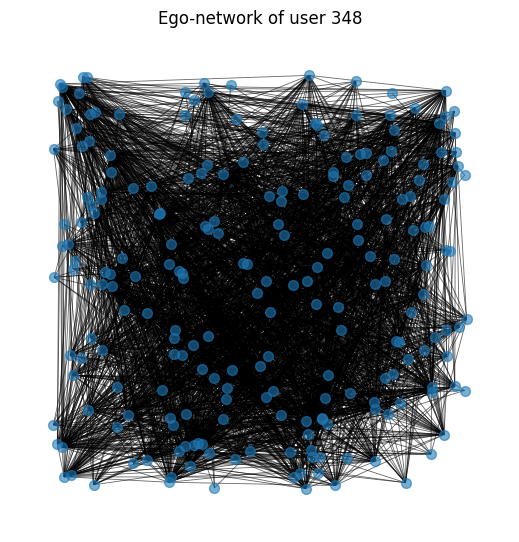

In [9]:
# Plot graph
plt.figure(figsize=(5,5))
pos = nx.random_layout(G, seed=42)
nx.draw(G, with_labels=False,  pos = pos, node_size = 50, alpha = 0.6, width = 0.6)
plt.title(f"Ego-network of user {dataset_id}")
plt.show()

But that visualization isn't very informative, since there is too much connections to distinguish anything. 

We'll focus on the different communities

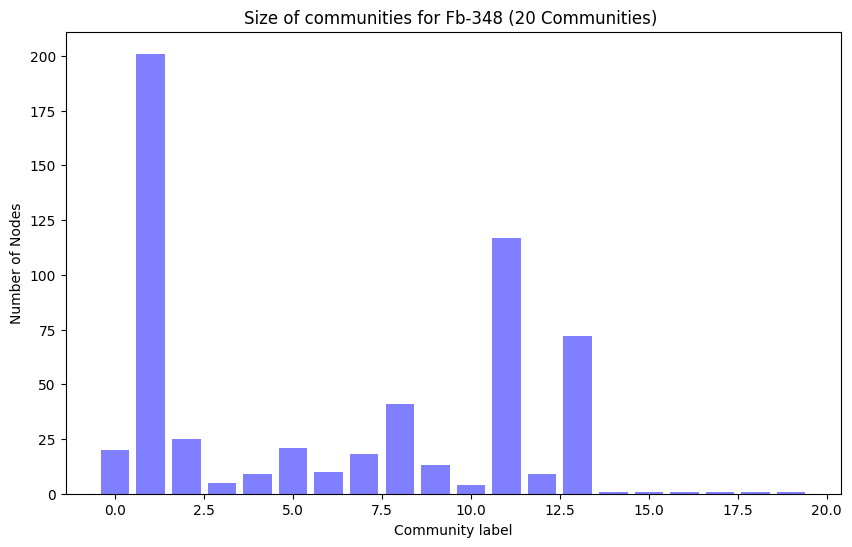

In [10]:
# Extract community labels and the corresponding number of nodes
true_com = defaultdict(int)
for node, coms in true_labels.items():
        for x in coms:
            true_com[x] += 1
        
true_communities = list(true_com.keys())  # Community labels
true_sizes = list(true_com.values())  # Number of nodes in each community

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(true_communities, true_sizes, color='blue', alpha=0.5)

# Add labels and title
plt.xlabel('Community label')
plt.ylabel('Number of Nodes')
plt.title(f'Size of communities for Fb-348 ({len(true_com)} Communities) ')

# Display the plot
plt.show()

We note that there is a big community (almost 200 members in an ego-network of 224 nodes), two other importants communities and smaller one. The dataset provides communities of different scales to work with.

### Useful functions

We need `dict_labels` to have the following format:
```
{   
    node1 : [com11, ..., com_1n],
    node2 : [com21, ..., com2m],
    ...
}
```

In [11]:
#An auxiliary function to plot the results

def show_boxplot(dict_labels: dict, algo_name: str):
    
    ### Extract community labels and the corresponding number of nodes, for the true labels
    true_com = defaultdict(int)
    for node, coms in true_labels.items():
            for x in coms:
                true_com[x] += 1
            
    true_communities = list(true_com.keys())  # Community labels
    true_sizes = list(true_com.values())  # Number of nodes in each community


    ### Extract community labels and the corresponding number of nodes, for the predicted labels
    count_com = defaultdict(int)
    for node, coms in dict_labels.items():
            for x in coms:
                count_com[x] += 1

    communities = [] # Community labels
    sizes = [] # Number of nodes in each community
    for com in range(max(len(true_com), len(count_com))):
            communities.append(com)
            if com in list(count_com.keys()):
                    sizes.append(count_com[com])
            else:
                    sizes.append(0)

    # Plot the data in louvain
    plt.figure(figsize=(10, 6))
    plt.bar(communities, sizes, alpha=0.5, label=f"{algo_name}")
    plt.bar(true_communities, true_sizes, alpha=0.5, label="True labels")

    # Add labels and title
    plt.xlabel('Community Label')
    plt.ylabel('Number of Nodes')
    plt.title(f'Number of Nodes per Community for {algo_name} ({len(count_com)} Communities)')

    # Display the plot
    plt.legend()
    plt.show()

To evaluate our results, we'll need some metrics. We discussed the choice of the metrics in the report

In [12]:
def scores(dict_labels: dict, algo_name: str, show=True):
    """
    Compute the accuracy, the omega index and the LFK omni score of dict_labels,
    based on true_labels.
    """

    ########## Accuracy
    s = 0
    for node in G.nodes():
        for x in true_labels[node]:
            if x in dict_labels[node]:
                s += 1 / max(len(true_labels[node]), len(dict_labels[node]))
    accuracy = s/len(G.nodes)

    # Convert to community-to-nodes format
    com_to_nodes = defaultdict(set)
    for node, coms in dict_labels.items():
        for com in coms:
            com_to_nodes[com].add(node)
    pred_communities = list(com_to_nodes.values())


    # Convert to community-to-nodes format
    com_to_nodes = defaultdict(set)
    for node, coms in true_labels.items():
        for com in coms:
            com_to_nodes[com].add(node)
    true_communities = list(com_to_nodes.values())

    # Convert to cdlib format
    true_clusters = NodeClustering(communities=true_communities, graph=G, method_name="ground_truth")
    pred_clusters = NodeClustering(communities=pred_communities, graph=G, method_name="predicted")
    
    ########## Omega Index
    omega = evaluation.omega(true_clusters, pred_clusters)
    ########## Accuracy
    onmi_score = evaluation.overlapping_normalized_mutual_information_LFK(true_clusters, pred_clusters)
    
    if show:
        print(f"Accuracy for {algo_name}: {accuracy:.4f}")
        print(f"Omega Index for {algo_name}: {omega.score:.4f}")
        print(f"ONMI for {algo_name}: {onmi_score.score:.4f}")

    return [accuracy, omega.score, onmi_score.score]


The algorithm will try to find the communities in a network, but the labels of these predicted communities will certainly not be the same as the groundtruth (for instance `predicted_6` and `true_labels_4` may design the same community but have different labels).
Therefore we use the *Hungarian algorithm* and perform linear programming to find the best mapping of labels

In [13]:
def align_labels(dict_labels):
    """
    Use of Hungarian algorithm to find best matching between dict_labels and true_labels community IDs. 
    """

    # number of predicted communities
    n1 = 0
    for node in dict_labels:
        for x in dict_labels[node]:
            if x > n1:
                n1 = x
    # true number of communities
    n2 = 0
    for node in true_labels:
        for x in true_labels[node]:
            if x > n2:
                n2 = x

    # Create confusion matrix
    cm = np.zeros((max(n1,n2) + 1, max(n1,n2) + 1))
    for node in dict_labels:
        for i in true_labels[node]:
            for j in dict_labels[node]:
                cm[i, j] += 1

    # Use Hungarian algorithm to find best matching
    row_ind, col_ind = linear_sum_assignment(-cm)  # maximize total score
    
    # Create a mapping from predicted label → true label
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    
    return mapping

# Louvain

We perform an exhaustive search to find the best hyperparameters, by maximizing the accuracy. Note that higher resolution $\Longrightarrow$ smaller communities

In [14]:
L_resolution = np.linspace(1e-2, 4, 100)

best_score = 0
for resolution in tqdm(L_resolution):

    louvain_partition = community_louvain.best_partition(G, resolution=resolution, random_state=42)

    for node in louvain_partition:
        louvain_partition[node] = [louvain_partition[node]]
    # Align labels
    mapping = align_labels(louvain_partition)
    #print("Mapping (pred → true):", mapping)

    # Assign each node the corresponding true label
    louvain_labels = defaultdict(list)
    for node in louvain_partition:
        for x in louvain_partition[node]:
            louvain_labels[node].append(mapping[x])
    
    L_scores = scores(louvain_labels, algo_name="Louvain", show=False)
    if L_scores[0] > best_score:
        best_score = L_scores[0]
        best_resolution = resolution

print(f"Best score = {best_score} and best resolution = {best_resolution}")


100%|██████████| 100/100 [00:22<00:00,  4.39it/s]

Best score = 0.35867346938775524 and best resolution = 0.6548484848484849


In [15]:
start = time.time()

# Apply Louvain algorithm
louvain_partition = community_louvain.best_partition(G, resolution=best_resolution, random_state=42)

for node in louvain_partition:
    louvain_partition[node] = [louvain_partition[node]]

# Align labels
mapping = align_labels(louvain_partition)
#print("Mapping (pred → true):", mapping)

# Assign each node the corresponding true label
louvain_labels = defaultdict(list)
for node in louvain_partition:
    for x in louvain_partition[node]:
        louvain_labels[node].append(mapping[x])

duration = time.time() - start

print(louvain_labels)

defaultdict(<class 'list'>, {436: [1], 428: [1], 450: [1], 531: [8], 538: [2], 404: [2], 565: [1], 412: [1], 471: [1], 461: [1], 544: [1], 414: [1], 465: [1], 546: [1], 547: [1], 475: [1], 446: [1], 536: [2], 398: [2], 367: [1], 452: [1], 560: [2], 493: [2], 361: [1], 359: [1], 402: [1], 520: [1], 567: [1], 542: [1], 510: [1], 521: [1], 559: [1], 557: [1], 376: [1], 555: [1], 500: [1], 469: [5], 516: [5], 378: [1], 482: [1], 418: [1], 506: [1], 514: [1], 545: [2], 525: [2], 484: [2], 492: [1], 479: [2], 373: [1], 483: [1], 173: [4], 549: [4], 460: [1], 517: [1], 395: [1], 370: [1], 396: [1], 416: [1], 368: [2], 503: [2], 423: [1], 457: [5], 477: [5], 524: [1], 364: [6], 441: [6], 400: [1], 548: [1], 515: [1], 434: [1], 496: [1], 382: [1], 474: [1], 451: [1], 409: [2], 526: [2], 363: [1], 371: [9], 420: [1], 432: [1], 448: [9], 563: [5], 508: [1], 440: [2], 444: [1], 523: [1], 561: [1], 365: [11], 507: [1], 397: [5], 439: [1], 497: [1], 513: [1], 387: [1], 408: [2], 512: [2], 394: [1], 

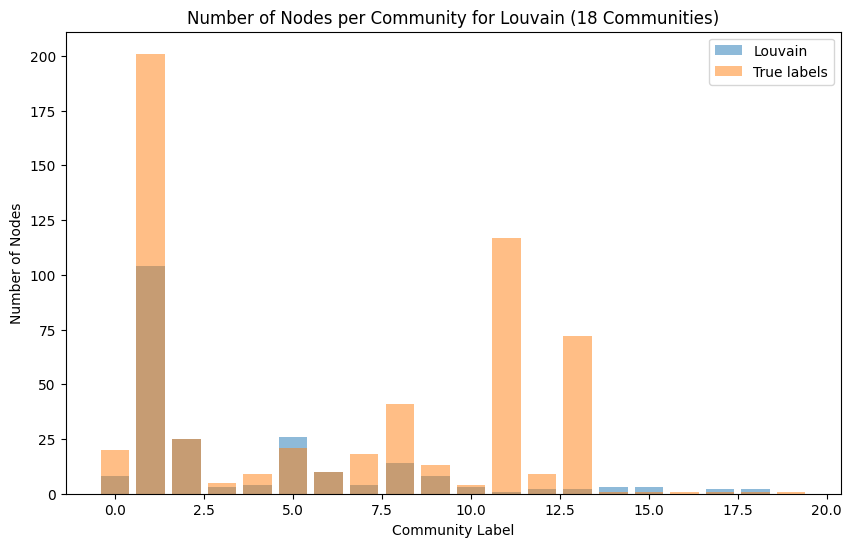

Accuracy for Louvain: 0.3587
Omega Index for Louvain: -0.0189
ONMI for Louvain: 0.3295
Time for Louvain: 0.0151 s


In [16]:
algo_name = "Louvain"

show_boxplot(louvain_labels, algo_name)
scores(louvain_labels, algo_name)
print(f"Time for {algo_name}: {duration:.4f} s")

We see that Louvain fails to recover the bigger communities. That was an excepcted result, since Louvain is designed to handle non-overlapping communities and prefers finding more small communities than a bigger one. 

## Leiden

In [17]:
# The implemented Leiden needs igraph format
G_ig = ig.Graph.from_networkx(G)

We perform an exhaustive search to find the best hyperparameters, by maximizing the accuracy.

In [18]:
L_resolution = np.linspace(1e-2, 4, 100)

best_score = 0
for resolution in tqdm(L_resolution):

    partition = la.find_partition(G_ig, la.RBConfigurationVertexPartition,
                                resolution_parameter=resolution, seed=42)
    # Print community assignments
    leiden_partition = {node: com for node, com in zip(G.nodes(), partition.membership)}

    for node in leiden_partition:
        leiden_partition[node] = [leiden_partition[node]]

    # Align labels
    mapping = align_labels(leiden_partition)
    #print("Mapping (pred → true):", mapping)

    # Assign each node the corresponding true label
    leiden_labels = defaultdict(list)
    for node in leiden_partition:
        for x in leiden_partition[node]:
            leiden_labels[node].append(mapping[x])

    
    L_scores = scores(leiden_labels, algo_name="Leiden", show=False)
    if L_scores[0] > best_score:
        best_score = L_scores[0]
        best_resolution = resolution

print(f"Best score = {best_score} and best resolution = {best_resolution}")


100%|██████████| 100/100 [00:19<00:00,  5.04it/s]

Best score = 0.4286139455782312 and best resolution = 0.05030303030303031


In [19]:
start = time.time()
partition = la.find_partition(G_ig, la.RBConfigurationVertexPartition,
                              resolution_parameter=best_resolution, seed=42)
# Print community assignments
leiden_partition = {node: com for node, com in zip(G.nodes(), partition.membership)}

for node in leiden_partition:
    leiden_partition[node] = [leiden_partition[node]]

# Align labels
mapping = align_labels(leiden_partition)
#print("Mapping (pred → true):", mapping)

# Assign each node the corresponding true label
leiden_labels = defaultdict(list)
for node in leiden_partition:
    for x in leiden_partition[node]:
        leiden_labels[node].append(mapping[x])

duration = time.time() - start

print(leiden_labels)

defaultdict(<class 'list'>, {436: [1], 428: [1], 450: [1], 531: [1], 538: [1], 404: [1], 565: [1], 412: [1], 471: [1], 461: [1], 544: [1], 414: [1], 465: [1], 546: [1], 547: [1], 475: [1], 446: [1], 536: [1], 398: [1], 367: [1], 452: [1], 560: [1], 493: [1], 361: [1], 359: [1], 402: [1], 520: [1], 567: [1], 542: [1], 510: [1], 521: [1], 559: [1], 557: [1], 376: [1], 555: [1], 500: [1], 469: [1], 516: [1], 378: [1], 482: [1], 418: [1], 506: [1], 514: [1], 545: [1], 525: [1], 484: [1], 492: [1], 479: [1], 373: [1], 483: [1], 173: [1], 549: [1], 460: [1], 517: [1], 395: [1], 370: [1], 396: [1], 416: [1], 368: [1], 503: [1], 423: [1], 457: [1], 477: [1], 524: [1], 364: [6], 441: [6], 400: [1], 548: [1], 515: [1], 434: [1], 496: [1], 382: [1], 474: [1], 451: [1], 409: [1], 526: [1], 363: [1], 371: [1], 420: [1], 432: [1], 448: [1], 563: [1], 508: [1], 440: [1], 444: [1], 523: [1], 561: [1], 365: [1], 507: [1], 397: [1], 439: [1], 497: [1], 513: [1], 387: [1], 408: [1], 512: [1], 394: [1], 4

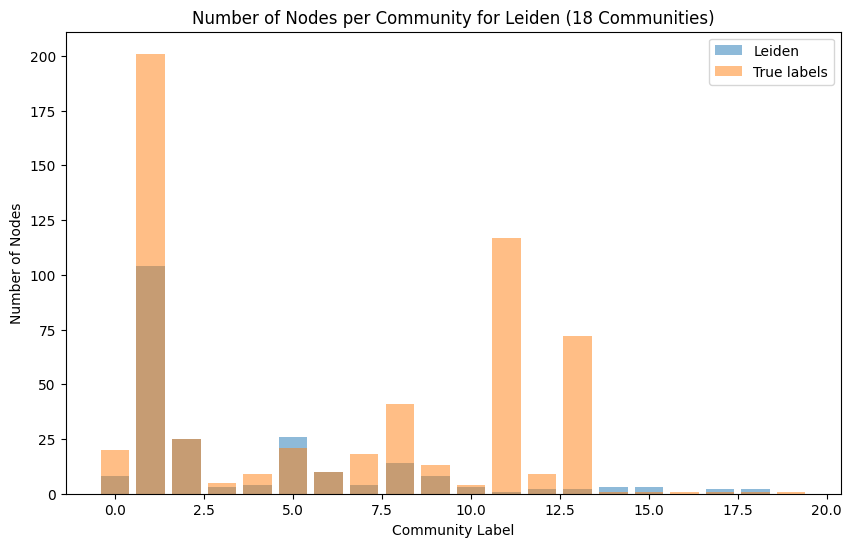

Accuracy for Leiden: 0.4286
Omega Index for Leiden: 0.1603
ONMI for Leiden: 0.4044
Time for Leiden: 0.0086 s


In [20]:
algo_name = "Leiden"

show_boxplot(louvain_labels, algo_name)
scores(leiden_labels, algo_name)
print(f"Time for {algo_name}: {duration:.4f} s")

As Louvain did, Leiden also fails to recover the bigger communities that overlaps on the smallest ones. That was also expected since Leiden is also designed only for non-overlapping communities and assign only one community to each node.

Another consideration : Leiden algorithm is 10 times faster than Louvain on this dataset. The times are negligible here, but that is a strong advantage of Leiden on Louvain.

As Louvain did, Leiden also fails to recover the bigger communities that overlaps on the smallest ones. That was also expected since Leiden is also designed only for non-overlapping communities and assign only one community to each node.

Another consideration : Leiden algorithm is 10 times faster than Louvain on this dataset. The times are negligible here, but that is a strong advantage of Leiden on Louvain.

# Clique-Based Louvain

We now use an algorithm specially designed for overlapping community detection and check if the results are improved. 

Details aboit Clique-Based Louvain Algorithm are given in the report.

In [21]:
def find_k_cliques(graph, k):
    """Find all cliques of size exactly k."""
    return [clique for clique in nx.find_cliques(graph) if len(clique) == k]


def reconstruct_graph(graph, k_cliques):
    """
    Replace each k-clique with a supernode and add self-loops.
    Maintain non-classified nodes (NCNs).
    """
    H = nx.Graph()
    node_to_clique = {}
    supernode_id = 0

    # Step 2: Convert each clique to a supernode with self-loop
    for clique in k_cliques:
        supernode = f"C{supernode_id}"
        supernode_id += 1
        H.add_node(supernode)
        num_edges = len(clique) * (len(clique) - 1) // 2
        H.add_edge(supernode, supernode, weight=num_edges)
        for node in clique:
            node_to_clique.setdefault(node, []).append(supernode)

    # Step 3: Add remaining nodes and original edges
    for u, v in graph.edges():
        clique_u = node_to_clique.get(u, None)
        clique_v = node_to_clique.get(v, None)

        if clique_u is None and clique_v is None:
            # Both are NCNs
            H.add_edge(u, v)
        elif clique_u is None:
            # u is NCN, v is in clique(s)
            for v_clique in clique_v:
                H.add_edge(u, v_clique)
        elif clique_v is None:
            # v is NCN, u is in clique(s)
            for u_clique in clique_u:
                H.add_edge(v, u_clique)
        else:
            # Both are part of cliques
            for cu in clique_u:
                for cv in clique_v:
                    if cu != cv:
                        H.add_edge(cu, cv)

    return H

In [ ]:
def apply_louvain(H, resolution=1.0):
    """Apply Louvain and return community partition."""
    partition = community_louvain.best_partition(H, resolution=resolution)
    communities = {}
    for node, comm_id in partition.items():
        communities.setdefault(comm_id, []).append(node)
    return list(communities.values())


def clique_based_louvain_cbla(graph, k, resolution=1.0):
    """
    Main function for Clique-Based Louvain Algorithm (CBLA).
    Based on provided algorithm steps.
    """
    k_cliques = find_k_cliques(graph, k)
    reconstructed_graph = reconstruct_graph(graph, k_cliques)

    # Step 4: Apply Louvain until NCNs are assigned
    communities = apply_louvain(reconstructed_graph, resolution)

    # Map back to original nodes
    node_assignments = {}
    for comm_id, nodes in enumerate(communities):
        for node in nodes:
            if isinstance(node, str) and node.startswith("C"):
                # Clique supernode: map to original clique nodes
                idx = int(node[1:])
                for original_node in k_cliques[idx]:
                    node_assignments.setdefault(original_node, set()).add(comm_id)
            else:
                # NCN node
                node_assignments.setdefault(node, set()).add(comm_id)

    return node_assignments

We perform an exhaustive search to find the best hyperparameters, by maximizing the accuracy.

In [ ]:
L_k = [1,2,3,4,5,6,7]
L_resolution = np.linspace(1e-2, 4, 100)

best_score = 0
for k in L_k:
    print(f"k = {k}")
    for resolution in tqdm(L_resolution):

        cb_louvain_partition = clique_based_louvain_cbla(G, k, resolution)
        for node in cb_louvain_partition:
            cb_louvain_partition[node] = list(cb_louvain_partition[node])

        # Align labels
        mapping = align_labels(cb_louvain_partition)
        #print("Mapping (pred → true):", mapping)

        # Assign each node the corresponding true label
        cb_louvain_labels = {node: [mapping[i] for i in cb_louvain_partition[node]] for node in cb_louvain_partition}

        L_scores = scores(cb_louvain_labels, algo_name="CB Louvain", show=False)
        if L_scores[0] > best_score:
            best_score = L_scores[0]
            best_k, best_resolution = k, resolution

    print(f"Best score = {best_score}")
print(f"Best k = {best_k} and best resolution = {best_resolution}")


k = 1


100%|██████████| 100/100 [00:27<00:00,  3.66it/s]


Best score = 0.3899234693877551
k = 2


100%|██████████| 100/100 [00:26<00:00,  3.76it/s]


Best score = 0.3899234693877551
k = 3


100%|██████████| 100/100 [00:29<00:00,  3.44it/s]


Best score = 0.3899234693877551
k = 4


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


Best score = 0.43493835034013595
k = 5


100%|██████████| 100/100 [02:04<00:00,  1.24s/it]


Best score = 0.46139455782312927
k = 6


100%|██████████| 100/100 [03:12<00:00,  1.93s/it]


Best score = 0.48405612244897933
k = 7


100%|██████████| 100/100 [07:49<00:00,  4.69s/it]

Best score = 0.48405612244897933
Best k = 6 and best resolution = 0.6951515151515152


In [24]:
start = time.time()

cb_louvain_partition = clique_based_louvain_cbla(G, best_k, best_resolution)
for node in cb_louvain_partition:
    cb_louvain_partition[node] = list(cb_louvain_partition[node])

# Align labels
mapping = align_labels(cb_louvain_partition)
#print("Mapping (pred → true):", mapping)

# Assign each node the corresponding true label
cb_louvain_labels = {node: [mapping[i] for i in cb_louvain_partition[node]] for node in cb_louvain_partition}
duration = time.time() - start

print(cb_louvain_labels)

{512: [2, 1], 517: [2, 1], 394: [2, 1], 515: [2, 1, 4], 513: [2, 1, 8, 12], 479: [2, 1], 484: [2], 408: [1], 516: [1], 457: [1], 459: [1], 357: [1], 563: [1, 11, 8], 518: [1], 435: [1], 389: [1], 551: [1], 424: [1], 369: [1], 521: [1], 452: [1], 500: [1, 0, 13], 506: [1], 475: [1, 4], 438: [1], 374: [1], 363: [1], 432: [1, 11, 7], 544: [1, 8], 504: [1], 537: [1], 416: [1], 483: [1], 503: [12, 1], 567: [12, 1], 419: [1], 420: [1], 569: [1], 430: [1, 11], 471: [1], 465: [12, 1, 0, 11], 514: [1], 566: [1], 539: [1], 391: [1], 366: [1], 400: [1, 0], 493: [1], 543: [1], 360: [1, 0], 402: [1, 11, 7], 570: [1], 460: [1, 0, 11], 558: [1, 0, 11], 545: [1, 7], 421: [1, 0], 372: [1], 362: [1, 0], 495: [1], 415: [1, 11], 428: [1, 11], 414: [1], 423: [1], 373: [1, 0, 11], 553: [1, 4, 7], 412: [1, 0], 560: [1], 395: [1], 417: [1], 542: [1, 11], 492: [1], 392: [1], 497: [1], 404: [1], 445: [1], 473: [1, 11], 565: [1], 355: [1, 13], 482: [1], 507: [1, 0], 496: [1], 350: [1], 455: [1, 13], 426: [1, 8],

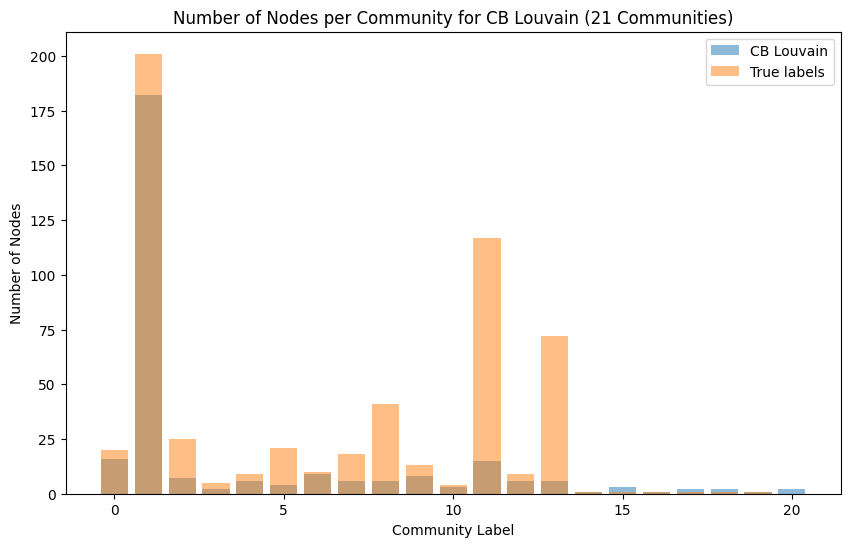

Accuracy for CB Louvain: 0.4290
Omega Index for CB Louvain: 0.1667
ONMI for CB Louvain: 0.2330
Time for CB Louvain: 1.2942 s


In [25]:
algo_name = "CB Louvain"

show_boxplot(cb_louvain_labels, algo_name)
scores(cb_louvain_labels, algo_name)
print(f"Time for {algo_name}: {duration:.4f} s")

First, we can see that the processing is drastically slower. Outside of the need to perform a search on the best clique size, the algorithm runs more than 50 times slower.

On the performances : we visually see that CBLA does not avoid to label nodes in a big community compared to the two previous algorithms. That is a first success.
We also compare the different metrics : since the optimization of the clique size is done based on the accuracy, it's no surprise that the accuracy is better for this model. But interesingly, the Omega index and ONMI are not better than Leiden results.

# Clique-Based Leiden

Finally, we try to use an hybrid version of Leiden and Clique-Louvain to see if it provides an improvment. This algorithm should handle overlapping communities

In [ ]:
def apply_leiden(H, resolution=1.0):
    """Apply Louvain and return community partition."""
    H_ig = ig.Graph.from_networkx(H)
    H_ig.vs["name"] = list(H.nodes())
    
    partition = la.find_partition(H_ig, la.RBConfigurationVertexPartition,
                              resolution_parameter=resolution)
    
    communities = {}
    for node_id, comm_id in enumerate(partition.membership):
        communities.setdefault(comm_id, []).append(H_ig.vs["name"][node_id])

    return list(communities.values())


def clique_based_leiden_cbla(G, k, resolution=1.0):
    """
    Main function for Clique-Based Leiden Algorithm
    """
    k_cliques = find_k_cliques(G, k)
    reconstructed_graph = reconstruct_graph(G, k_cliques)

    communities = apply_leiden(reconstructed_graph, resolution)
    # Map back to original nodes
    node_assignments = {}
    for comm_id, nodes in enumerate(communities):
        for node in nodes:
            if isinstance(node, str) and node.startswith("C"):
                # Clique supernode: map to original clique nodes
                idx = int(node[1:])
                for original_node in k_cliques[idx]:
                    node_assignments.setdefault(original_node, set()).add(comm_id)
            else:
                # NCN node
                node_assignments.setdefault(node, set()).add(comm_id)

    return node_assignments

We perform an exhaustive search to find the best hyperparameters, by maximizing the accuracy.

In [ ]:
L_k = [1,2,3,4,5,6,7]
L_resolution = np.linspace(1e-2, 4, 100)

best_score = 0
for k in L_k:
    print(f"k = {k}")
    for resolution in tqdm(L_resolution):

        cb_leiden_partition = clique_based_leiden_cbla(G, k, resolution)
        for node in cb_leiden_partition:
            cb_leiden_partition[node] = list(cb_leiden_partition[node])

        # Align labels
        mapping = align_labels(cb_leiden_partition)
        #print("Mapping (pred → true):", mapping)

        # Assign each node the corresponding true label
        cb_leiden_labels = {node: [mapping[i] for i in cb_leiden_partition[node]] for node in cb_leiden_partition}

        L_scores = scores(cb_leiden_labels, algo_name="CB Leiden", show=False)
        if L_scores[0] > best_score:
            best_score = L_scores[0]
            best_k, best_resolution = k, resolution

    print(f"Best score = {best_score}")
print(f"Best k = {best_k} and best resolution = {best_resolution}")


k = 1


100%|██████████| 100/100 [00:24<00:00,  4.14it/s]


Best score = 0.4286139455782312
k = 2


100%|██████████| 100/100 [00:23<00:00,  4.25it/s]


Best score = 0.4286139455782312
k = 3


100%|██████████| 100/100 [00:27<00:00,  3.69it/s]


Best score = 0.4286139455782312
k = 4


100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


Best score = 0.4330782312925169
k = 5


100%|██████████| 100/100 [01:51<00:00,  1.11s/it]


Best score = 0.4330782312925169
k = 6


100%|██████████| 100/100 [02:57<00:00,  1.77s/it]


Best score = 0.4469175170068028
k = 7


100%|██████████| 100/100 [07:33<00:00,  4.53s/it]

Best score = 0.4469175170068028
Best k = 6 and best resolution = 0.9772727272727273


In [28]:
start = time.time()

cb_leiden_partition = clique_based_leiden_cbla(G, best_k, best_resolution)
for node in cb_leiden_partition:
    cb_leiden_partition[node] = list(cb_leiden_partition[node])

# Align labels
mapping = align_labels(cb_leiden_partition)
#print("Mapping (pred → true):", mapping)

# Assign each node the corresponding true label
cb_leiden_labels = {node: [mapping[i] for i in cb_leiden_partition[node]] for node in cb_leiden_partition}
duration = time.time() - start

print(cb_leiden_labels)

{512: [11], 517: [11, 13], 394: [11], 515: [11, 13], 513: [11, 1, 13], 479: [11], 408: [11], 537: [11], 416: [11, 1], 483: [11, 1, 13], 503: [11], 567: [11, 1], 419: [11, 1], 420: [11, 1, 13], 569: [11], 430: [11, 1], 471: [11, 13], 465: [11, 13], 514: [11, 13], 566: [11, 13], 539: [11], 391: [11, 13], 366: [11, 13], 400: [11, 13], 493: [11], 543: [11], 360: [11, 13], 402: [11, 1, 13], 570: [11, 1], 460: [11, 13], 558: [11, 13], 545: [11], 421: [11], 372: [11], 362: [11], 412: [11, 1, 13], 373: [11, 13], 495: [11], 415: [11], 428: [11, 1, 13], 414: [11, 13], 423: [11, 13], 560: [11], 553: [11, 1, 13], 395: [11], 417: [11], 542: [11, 13], 492: [11], 392: [11, 13], 497: [11, 1, 13], 404: [11], 445: [11], 500: [11, 1, 13], 473: [11, 13], 565: [11, 13], 482: [11, 13], 374: [11, 1, 13], 507: [11, 1, 13], 496: [11, 13], 363: [11, 1, 13], 463: [11, 1, 13], 368: [11], 494: [11], 527: [11], 559: [11], 422: [11, 1], 444: [11, 1, 13], 376: [11, 1, 13], 426: [11, 1, 13], 524: [11, 13], 544: [11, 1

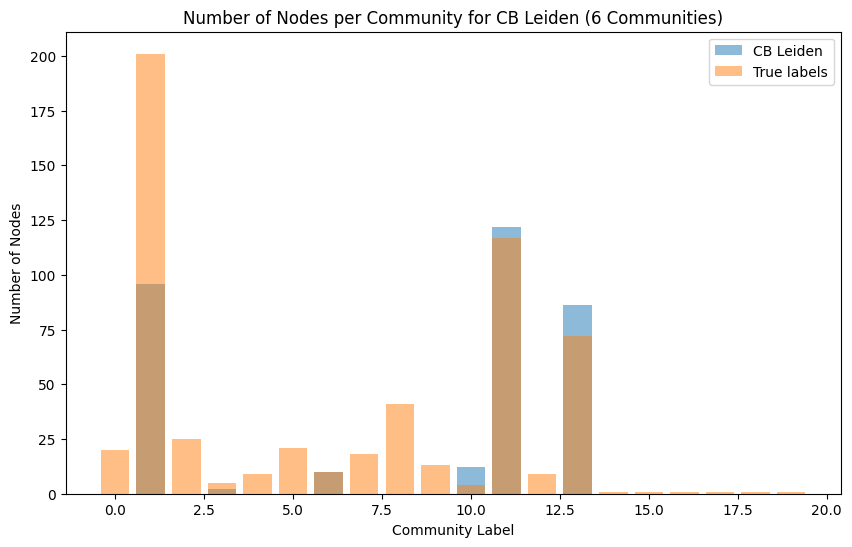

Accuracy for CB Leiden: 0.4469
Omega Index for CB Leiden: 0.0818
ONMI for CB Leiden: 0.2360
Time for CB Leiden: 0.5837 s


In [29]:
algo_name = "CB Leiden"

show_boxplot(cb_leiden_labels, algo_name)
scores(cb_leiden_labels, algo_name)
print(f"Time for {algo_name}: {duration:.4f} s")

Here we can see that Clique Based Leiden is missing a lot of communities and only find 6 (against 19 in groundtruth). That probably explain its poor results. 

# Comparison

In [30]:
partitions = [louvain_labels, leiden_labels, cb_louvain_labels, cb_leiden_labels]
algo_names = ["louvain", "leiden", "CB Louvain", "CB Leiden"]
for partition, algo_name in zip(partitions, algo_names):
    print(f"========= {algo_name} =========")
    scores(partition, algo_name)
    print("\n")

========= louvain =========
Accuracy for louvain: 0.3587
Omega Index for louvain: -0.0189
ONMI for louvain: 0.3295


========= leiden =========
Accuracy for leiden: 0.4286
Omega Index for leiden: 0.1603
ONMI for leiden: 0.4044


========= CB Louvain =========
Accuracy for CB Louvain: 0.4290
Omega Index for CB Louvain: 0.1667
ONMI for CB Louvain: 0.2330


========= CB Leiden =========
Accuracy for CB Leiden: 0.4469
Omega Index for CB Leiden: 0.0818
ONMI for CB Leiden: 0.2360




# Conclusion
We can see that CB Louvain and CB Leiden both perform better in accuracy than their basic versions. However, basic Leiden algorithm  performs well w.r.t. other metrics.

That shows that the clique base method doesn't drastically improve the results for this ego-network. Maybe the method is too simplistic and deep learning is the key to perform a better community detection.